# In-class exercise week 4: Tracing dynamic similarity between quality and fake news sources

One may wonder to what extent fake news sources follow the agenda of quality news outlets. In this assignment, we try to map the overlap in articles (i.e., agenda convergence) published by Infowars, an extreme right/ fake news source, and BBC and The Guardian on the other hand--which are generally considered high quality news sources.

specifically, in this notebook, we will use and compare two methods of similarity: `cosine` and `soft-cosine`. 

You can find, and download, the full dataset here:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ULHLCB

For this assignment, you can work with the same data that we used for week 2 (`articles.zip`) 

<br>

<div class="alert-warning">
Please run the code step by step and try to follow what is happening. You do not have to understand all lines of code (especially the helper functions might contain code that you do not yet understand). 
</div>

### Reading in the data

In [1]:
PATH = '/Users/anne/repos/CCS2NEW/CCS-2/week02/exercises/articles'

#PATH = 'path/to/folder/with/articles' #use the data that we've also worked with in week 2


from glob import glob
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

## Take a random sample

Set a random number, of max `2000` (if you work with the smaller datafile from Canvas). However, you can also set this value to 20 or so, just for the purpose of practice--and speeding up the code

In [2]:
RANDOM_N = 2000

In [3]:
# this is a helper function to read in the data; you can try to follow the code but it's not necessary that you understand all parts.

def read_data(listofoutlets, RANDOM_N):
    
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
                
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars', 'BBC', 'The Guardian'], RANDOM_N)

In [4]:
dates[0], title[0], texts[0], outlets[0]

('2018-04-24',
 'Video MSNBC Host Scarborough Says White House Physician Is Like Hitlers Doctor',
 "MSNBC host Joe Scarborough told viewers Monday that the Presidents physician sounds like Hitlers doctor, in an effort to derail the former Navy physicians nomination by Trump for secretary of veterans affairs.\n\nDr Ronny Jackson, an Iraq War veteran, has been nominated by Trump to succeed David Shulkin, but is facing allegations, according to anonymous sources cited by CBS, of creating a hostile work environment, as well as excessive drinking on the job and improperly dispensing meds.\n\nThis provided enough ammunition for Joe Scarborough and his motley crew to attempt a character assassination, based mainly on Jackson, who was also Barack Obamas doctor, issuing Trump a clean bill of health earlier in the year.\n\nYou dont have to be one of those people that work at circuses that look, Hey, I can guess your weight, to know that Donald Trump weighs a hell of a lot more than 239 pounds. T

In [5]:
dates_formatted = [parser.parse(e).strftime("%Y-%b") for e in dates]
dates_formatted[0:4]

['2018-Apr', '2018-Jun', '2018-Mar', '2018-May']


<u>Question 1</u> 

 <br>

<div class="alert-info">
Expect the content of the dates, title, texts, outlets objects. 
Can you understand the code above? Why are we formatting the date variable?  <br>
Check the type of data you are working with, print the first entry of each list, perform some sanity checks.
</div>

    An example of a sanity check if for example to check whether all the lists are of equal length (which you would expect here)
```python

assert len(dates) == len(title) == len(texts) == len(outlets)# example sanity checks
```


### Initialize a time frame

Ultimatly, we would like to have observations (i.e., cosine similarity scores) for each month in the period 2018. It might be, however, that we cannot calculate values for each month (incase we have missings). To avoid ending up with missing months in our dataframe, we create this list before the start of our analysis.

In [6]:
lists_of_dates = pd.date_range('2018-01-01','2019-01-01', freq='MS').strftime("%Y-%b").tolist()

# 1. Dynamic Agenda overlap with Cosine Similarity 
We use`sklearn`'s`cosine_similarity` to calculate cosine similarity scores

### Vectorize the data

In [7]:
vec = CountVectorizer(stop_words='english')
count_matrix = vec.fit(texts) # fit on all the data
transformed_text = vec.transform(texts)

<u>Question 2</u> 
<br>
<br>
<div class="alert-info">
Can you change the code in the cell above? <br>
e.g., use pruning rather than stopword removal, or transform the data using the tfidf algorithm.
</div>


### helper function: Create list of tuples, for each of the outlets. 

In [8]:
combined = list(zip(dates_formatted, title, texts, outlets, transformed_text))

infowars = [e for e in combined if e[3]=='Infowars']
bbc = [e for e in combined if e[3]=='BBC']
guardian = [e for e in combined if e[3]=='The Guardian']

### Calcuting Cosine Similarity scores across outlets overtime

The next utility function will calculate cosine similarity scores between two agendas, in chuncks of months. More specifically, for each month of our selected time frame, we will calculate cosine similarity scores between articles from a fake news source on the one hand (`infowars`), and a quality news source on the other (`BBC`)

In [9]:
## Helper function: get cosine similarity scores overtime

def get_cosine_overtime(source1, source2, list_of_dates):
    
    '''calculate cosine similarity sources between articles nested within months'''

    time_frame = []
    monthly_cosine_similarity = []
    number_of_combinations = []

    for month in tqdm(lists_of_dates):
        
        all_combinations = []

        source1_comparison = [i for i in source1 if i[0]==month]
        source2_comparison = [i for i in source2 if i[0]==month]

        for i in source1_comparison:
            single_combinations = []
            for e in source2_comparison:
                
                assert month == i[0] == e[0] #sanity check
                
                sim_score = cosine_similarity(i[4], e[4])
                single_combinations.append(sim_score[0][0])

            all_combinations.extend(single_combinations)

        time_frame.append(month)
        monthly_cosine_similarity.append(np.mean(all_combinations))
        number_of_combinations.append(len(all_combinations))
    return [time_frame, monthly_cosine_similarity, number_of_combinations]

In [10]:
results_guardian_bbc = get_cosine_overtime(guardian, bbc, lists_of_dates) 

  0%|          | 0/13 [00:00<?, ?it/s]/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [06:26<00:00, 29.72s/it]


Do you understand what is returned by the function`get_cosine_overtime()`?  


Can you guess what is in `results_guardian_bbc[1]`? and `results_guardian_bbc[1]`? and `results_guardian_bbc[2]`?

In [11]:
len(results_guardian_bbc[0]) 

13

In [12]:
results_guardian_bbc[0]

['2018-Jan',
 '2018-Feb',
 '2018-Mar',
 '2018-Apr',
 '2018-May',
 '2018-Jun',
 '2018-Jul',
 '2018-Aug',
 '2018-Sep',
 '2018-Oct',
 '2018-Nov',
 '2018-Dec',
 '2019-Jan']

In [13]:
results_guardian_infowars = get_cosine_overtime(guardian, infowars, lists_of_dates)

100%|██████████| 13/13 [07:06<00:00, 32.83s/it]


In [14]:
results_bbc_infowars = get_cosine_overtime(bbc, infowars, lists_of_dates)

100%|██████████| 13/13 [06:47<00:00, 31.33s/it]


### Convert meta data to a dataframe
To inspect the data, and maybe visualize it, it might be nice to convert it to a tabular format. 

In [15]:
def get_meta_dataframe(combined_data):
    df = pd.DataFrame(combined)
    df.columns = ['date', 'title', 'text', 'outlet', 'vectorized']

    df['Infowars'] = np.where(df['outlet'] == 'Infowars', 1,0)
    df['BBC'] = np.where(df['outlet'] == 'BBC', 1,0)
    df['The Guardian'] = np.where(df['outlet'] == 'The Guardian', 1,0)

    # aggregate the dataframe on the level of months, with number of articles within outlets in the rows:
    df = df.groupby('date')[['Infowars', 'BBC', 'The Guardian']].sum()
    
    return df

df = get_meta_dataframe(combined)
df.head()

,Infowars,BBC,The Guardian
date,,,
2018-Apr,182,194,155
2018-Aug,217,234,206
2018-Feb,181,179,150
2018-Jul,212,278,171
2018-Jun,157,109,102


### Create a df with the cosine similairy scores between two agendas

In [16]:
def get_cosine_frame(results, source1, source2):
    cosine = pd.DataFrame(results).T
    cosine.rename(columns={0: 'date', 1:f'cosine_{source1}_{source2}', 2: f'combinations_{source1}_{source2}'},inplace=True)
    cosine = cosine.set_index('date')
    return cosine

cosine_guardian_bbc = get_cosine_frame(results_guardian_bbc,'guardian', 'bbc')
cosine_guardian_infowars = get_cosine_frame(results_guardian_infowars,'guardian', 'infowars')
cosine_bbc_infowars = get_cosine_frame(results_bbc_infowars,'bbc', 'infowars')

In [17]:
df = pd.merge(cosine_guardian_bbc, df, left_index=True, right_index=True, how='inner')
df = pd.merge(cosine_guardian_infowars, df, left_index=True, right_index=True, how = 'inner')
df = pd.merge(cosine_bbc_infowars, df, left_index=True, right_index=True, how = 'inner')

In [18]:
df

,cosine_bbc_infowars,combinations_bbc_infowars,cosine_guardian_infowars,combinations_guardian_infowars,cosine_guardian_bbc,combinations_guardian_bbc,Infowars,BBC,The Guardian
date,,,,,,,,,
2018-Feb,0.041655,32399,0.080781,27150,0.062209,26850,181,179,150
2018-Mar,0.042727,44694,0.07406,39312,0.067103,32088,234,191,168
2018-Apr,0.040706,35308,0.080181,28210,0.062874,30070,182,194,155
2018-May,0.042531,39728,0.09309,36099,0.067893,39312,191,208,189
2018-Jun,0.044762,17113,0.092235,16014,0.072358,11118,157,109,102
2018-Jul,0.038687,58936,0.086271,36252,0.077408,47538,212,278,171
2018-Aug,0.039975,50778,0.09395,44702,0.059038,48204,217,234,206
2018-Sep,0.035999,38579,0.074541,46161,0.060478,35811,223,173,207
2018-Oct,0.041682,52514,0.086818,70422,0.063274,63147,242,217,291


<u>Question 3</u> 
<br>
<br>
<div class="alert-info">
Inspect the results. Where do you see the highest overlap? Which agendas have the highest overlap? Does Infowars follow the agenda of The Guardian or the BBC more closely?<br>
Is this what you expected?
</div>


<u>Question 4</u> 
<br>
<br>
<div class="alert-info">
Adjust the code, e.g., by changing the vectorizer, and inspect the effects thereof in the final results.<br>
Is this more in line with what you would expect? 
</div>


### Visualize 

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(9,7)})
sns.set_style("white")

Before we can draw a lineplot, we need to change the dataframe from a wide to a long format. That what we will do next. 

In [20]:
df.index = pd.to_datetime(df.index)
df = df.reset_index()

long = pd.melt(df, id_vars = 'date', value_vars = ['cosine_guardian_infowars', 'cosine_guardian_bbc', 'cosine_bbc_infowars'], var_name='agendas', value_name='cosine_similarity')
long["cosine_similarity"] = pd.to_numeric(long["cosine_similarity"], downcast="float")

<AxesSubplot:xlabel='date', ylabel='cosine_similarity'>

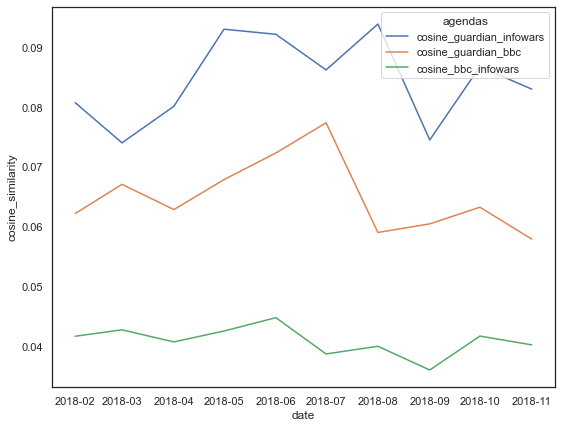

In [21]:
sns.lineplot(x='date', y='cosine_similarity', hue='agendas', data=long)

You may wonder how overlap relates to absolute attention (=number of articles published within months within the outlets). We can plot both simultaneously in one graph.

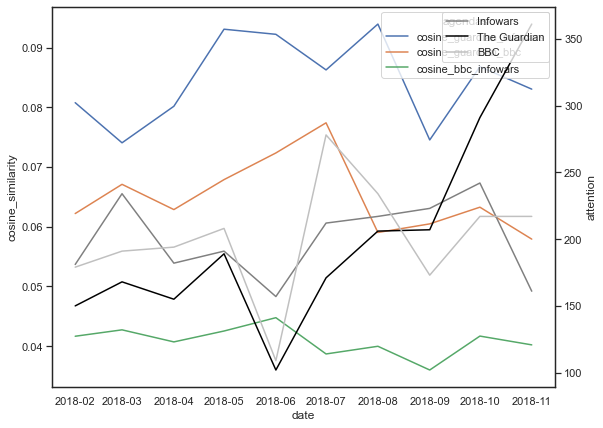

In [22]:
long_attention = pd.melt(df, id_vars = 'date', value_vars = ['Infowars', 'The Guardian', 'BBC'], var_name='outlets', value_name='attention')

sns.lineplot(x='date', y='cosine_similarity', hue='agendas', data=long)
ax2 = plt.twinx()
sns.lineplot(x='date',y='attention', hue='outlets', palette=['grey', 'black', 'silver'], data=long_attention, ax=ax2)
plt.legend(loc='upper right')

<u>Question 5</u> 
<br>
<br>
<div class="alert-info">
Does this make sense? Can you see a (reverse) relation between absolute attention and cosine scores?
</div>


# 2. Dynamic Agenda overlap with Soft-Cosine Similarity 
Here, we will use `gensim`

In [23]:
import gensim
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import WordEmbeddingSimilarityIndex
print(gensim.__version__)

from gensim.corpora import Dictionary
import numpy as np

4.1.2


In [24]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.


### Load the model...
<br>
<div class="alert-danger">
Please note that the next block may take a while to run...
</div>

In [25]:
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

In [26]:
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in texts]) #initialize a Dictionary

<div class="alert-danger">
Please note that the next block may take a while to run...
</div>

In [27]:
similarity_index = WordEmbeddingSimilarityIndex(fasttext_model300)
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary) # Build a term similarity matrix and compute the Soft Cosine Measure.

100%|██████████| 45286/45286 [32:11<00:00, 23.45it/s]


In [28]:
bag_of_words_vectors = [ dictionary.doc2bow(simple_preprocess(doc)) for doc in texts]

In [29]:
combined = list(zip(dates_formatted, title, texts, outlets, bag_of_words_vectors))

infowars = [e for e in combined if e[3]=='Infowars']
bbc = [e for e in combined if e[3]=='BBC']
guardian = [e for e in combined if e[3]=='The Guardian']

In [30]:
#similarity_matrix.inner_product(infowars[0][4], infowars[1][4], normalized=(True, True))

Please check the data...

e.g.,by printing **parts** of the lists, using list slicing;

```python
bbc[0]
```

In [31]:
def get_soft_cosine_overtime(source1, source2, lists_of_dates):

    '''Adjusted function, estimates the soft cosine similarity'''
    
    time_frame = []
    monthly_cosine_similarity = []
    number_of_combinations = []

    for month in tqdm(lists_of_dates):
        
        all_combinations = []

        source1_comparison = [i for i in source1 if i[0]==month]
        source2_comparison = [i for i in source2 if i[0]==month]

        for i in source1_comparison:
            
            single_combinations = []
            for e in source2_comparison:
                
                assert month == i[0] == e[0] #sanity check
                
                sim_score = similarity_matrix.inner_product(i[4], e[4], normalized=(True, True))
                single_combinations.append(sim_score)

            all_combinations.extend(single_combinations)

        time_frame.append(month)
        monthly_cosine_similarity.append(np.mean(all_combinations))
        number_of_combinations.append(len(all_combinations))
    return [time_frame, monthly_cosine_similarity, number_of_combinations]

<u>Question 6</u> 
<br>
<br>
<div class="alert-info">
Can you tell where this function differs? Where is the soft cosine (rather than the regular cosine) calculated?
</div>


In [32]:
results_guardian_infowars = get_soft_cosine_overtime(guardian, infowars, lists_of_dates)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [13:21<00:00, 61.66s/it] 


In [33]:
results_guardian_bbc = get_soft_cosine_overtime(guardian, bbc, lists_of_dates)

100%|██████████| 13/13 [16:02<00:00, 74.05s/it] 


In [34]:
results_bbc_infowars = get_soft_cosine_overtime(bbc, infowars, lists_of_dates)

100%|██████████| 13/13 [09:45<00:00, 45.02s/it]


### Get data in `df` object

In [35]:
df = get_meta_dataframe(combined)
df

,Infowars,BBC,The Guardian
date,,,
2018-Apr,182,194,155
2018-Aug,217,234,206
2018-Feb,181,179,150
2018-Jul,212,278,171
2018-Jun,157,109,102
2018-Mar,234,191,168
2018-May,191,208,189
2018-Nov,161,217,361
2018-Oct,242,217,291


In [36]:
def get_soft_cosine_frame(results, source1, source2):
    cosine = pd.DataFrame(results).T
    cosine.rename(columns={0: 'date', 1:f'soft_cosine_{source1}_{source2}', 2: f'combinations_{source1}_{source2}'},inplace=True)
    cosine = cosine.set_index('date')
    return cosine

soft_cosine_guardian_bbc = get_soft_cosine_frame(results_guardian_bbc,'guardian', 'bbc')
soft_cosine_guardian_infowars = get_soft_cosine_frame(results_guardian_infowars,'guardian', 'infowars')
soft_cosine_bbc_infowars = get_soft_cosine_frame(results_bbc_infowars,'bbc', 'infowars')

In [37]:
df = pd.merge(soft_cosine_guardian_bbc, df, left_index=True, right_index=True, how='inner')
df = pd.merge(soft_cosine_guardian_infowars, df, left_index=True, right_index=True, how='inner')
df = pd.merge(soft_cosine_bbc_infowars, df, left_index=True, right_index=True, how='inner')

In [38]:
df

,soft_cosine_bbc_infowars,combinations_bbc_infowars,soft_cosine_guardian_infowars,combinations_guardian_infowars,soft_cosine_guardian_bbc,combinations_guardian_bbc,Infowars,BBC,The Guardian
date,,,,,,,,,
2018-Feb,0.741563,32399,0.786899,27150,0.804034,26850,181,179,150
2018-Mar,0.728429,44694,0.775826,39312,0.802768,32088,234,191,168
2018-Apr,0.739039,35308,0.780447,28210,0.816325,30070,182,194,155
2018-May,0.725314,39728,0.798731,36099,0.798897,39312,191,208,189
2018-Jun,0.743768,17113,0.788682,16014,0.821545,11118,157,109,102
2018-Jul,0.705866,58936,0.750774,36252,0.807904,47538,212,278,171
2018-Aug,0.72629,50778,0.796651,44702,0.795043,48204,217,234,206
2018-Sep,0.697849,38579,0.727747,46161,0.785868,35811,223,173,207
2018-Oct,0.739317,52514,0.768557,70422,0.818871,63147,242,217,291


### visualize

In [39]:
df.index = pd.to_datetime(df.index)
df = df.reset_index()
long = pd.melt(df, id_vars = 'date', value_vars = ['soft_cosine_guardian_infowars','soft_cosine_guardian_bbc', 'soft_cosine_bbc_infowars'], var_name='Outlets', value_name='Soft Cosine Similarity')

<AxesSubplot:xlabel='date', ylabel='Soft Cosine Similarity'>

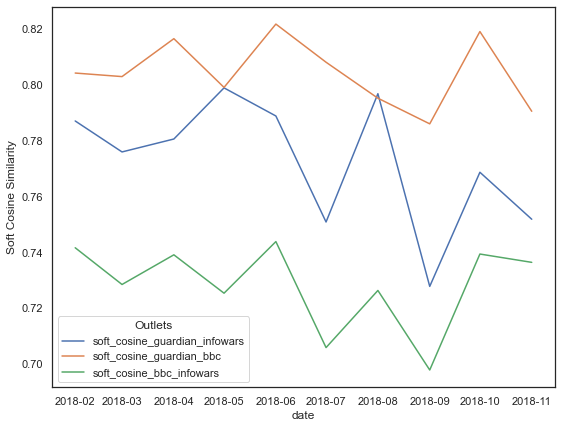

In [40]:
long["Soft Cosine Similarity"] = pd.to_numeric(long["Soft Cosine Similarity"], downcast="float")
sns.lineplot(x='date', y='Soft Cosine Similarity', hue='Outlets', data=long)


<u>Question 7</u> 
<br>
<br>
<div class="alert-info">
Compare these findings to regular cosine findings. Are you suprised by the difference in these findings? What strikes you most?
</div>
